In [1]:
import os
from glob import glob
import hashlib
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from copy import deepcopy
import ipynbname
import matplotlib.pyplot as plt
import shap
from datetime import datetime
import re

# Constants
EXPERIMENT_NAME = "nursing_home"
DATA_PATH = f"..{os.sep}..{os.sep}data{os.sep}"

In [2]:
current_time = datetime.now()
print("Current time is:",current_time)

nb_fname = ipynbname.name()
print("File:",nb_fname)

experiment_number = int(re.findall(r'\d+', nb_fname)[0])
print(f"Experiment Number: {experiment_number}")  # Output: 01

Current time is: 2025-03-05 17:38:58.042578
File: machine_learning_experiment08
Experiment Number: 8


In [3]:
# Function to generate a consistent hash number for a given file name
def generate_hash_number(file_name):
    """
    Generates a consistent hash number based on the file name.
    
    Args:
        file_name (str): The file name to hash.
    
    Returns:
        int: A 32-bit hash number.
    """
    # Create an MD5 hash object
    hash_obj = hashlib.md5()
    
    # Update the hash object with the file name, encoded to bytes
    hash_obj.update(file_name.encode())

    # Convert the hash to an integer and ensure the range fits 32-bit
    return int(hash_obj.hexdigest(), 16) % (2**32)

# Generate experiment seed from experiment name
initial_seed = generate_hash_number(EXPERIMENT_NAME)
print(f"Experiment Name: {EXPERIMENT_NAME}, Initial Seed: {initial_seed}")

Experiment Name: nursing_home, Initial Seed: 127573839


In [4]:
# Set the seed for reproducibility
np.random.seed(initial_seed)

# Generate a list of 5 random integers in the range of 32-bit integers
random_integers_list = np.random.randint(low=0, high=2**31 - 1, size=10).tolist()
print("Random Integers List:", random_integers_list)
seed = random_integers_list[experiment_number-1]
# Load clinical microbiome data
df_path = glob(f'{DATA_PATH}*clinical_microbiome_df*')[0]
print(f"Data File Path: {df_path}")

clinical_microbiome_df = pd.read_csv(df_path)
print("Clinical Microbiome Data Loaded.")

# Display value counts for the 'Alzheimers' column
alzheimers_counts = clinical_microbiome_df['Alzheimers'].value_counts()
alzheimers_counts_normalized = clinical_microbiome_df['Alzheimers'].value_counts(normalize=True)

print("Alzheimers Counts:\n", alzheimers_counts)
print("Normalized Alzheimers Counts:\n", alzheimers_counts_normalized)
print(f"Seed in this experiment: {seed}")

Random Integers List: [315491657, 135304577, 1572185508, 1029933563, 1950160822, 563269619, 1573902777, 513873336, 442822283, 1770168448]
Data File Path: ../../data/clinical_microbiome_df.csv
Clinical Microbiome Data Loaded.
Alzheimers Counts:
 Alzheimers
0.0    225
1.0    110
Name: count, dtype: int64
Normalized Alzheimers Counts:
 Alzheimers
0.0    0.671642
1.0    0.328358
Name: proportion, dtype: float64
Seed in this experiment: 513873336


In [5]:
clinical_microbiome_df["Dementia Other"].value_counts()

Dementia Other
0    335
Name: count, dtype: int64

In [6]:
clinical_microbiome_df = clinical_microbiome_df[clinical_microbiome_df["Dementia Other"] != 1]
# Display value counts for the 'Alzheimers' column
alzheimers_counts = clinical_microbiome_df['Alzheimers'].value_counts()
alzheimers_counts_normalized = clinical_microbiome_df['Alzheimers'].value_counts(normalize=True)
print("Alzheimers Counts:\n", alzheimers_counts)
print("Normalized Alzheimers Counts:\n", alzheimers_counts_normalized)

Alzheimers Counts:
 Alzheimers
0.0    225
1.0    110
Name: count, dtype: int64
Normalized Alzheimers Counts:
 Alzheimers
0.0    0.671642
1.0    0.328358
Name: proportion, dtype: float64


In [7]:
clinical_summaries_df = pd.read_csv(glob(f"..{os.sep}..{os.sep}data{os.sep}clinical_summaries_df*")[0])
clinical_summaries_df

,feature_name,definition,feature_group_characteristics,feature_description,feature_description_down_sized
0,Sample ID,Unique identifier for biological or clinical s...,Study Identification,### Clinical Feature Summary\n\n#### Feature: ...,the Sample ID is crucial for maintaining the i...
1,study_id,Identifier for the specific study or research ...,Study Identification,"### Clinical Feature Definitions, Scope, and R...",study identification ### Clinical Feature Defi...
2,day,Day of data collection or relevant event.,Temporal Information,### Clinical Feature Summary for Alzheimer's D...,this feature provides temporal information tha...
3,Date Sample,Date when the sample was collected.,Temporal Information,### Clinical Feature Summary\n\n#### Feature: ...,"the ""Date Sample"" refers to the specific date ..."
4,age,Age of the participant.,Demographic Information,### Clinical Feature Summary: Age\n\n**Definit...,age is a fundamental demographic characteristi...
...,...,...,...,...,...
98,Severe Liver disease,Advanced liver disease diagnosis.,Hepatic Condition,### Clinical Feature: Severe Liver Disease\n\n...,"cirrhosis, steatohepatitis, and liver failure ..."
99,ostomy,Presence of an ostomy.,Surgical History,### Clinical Feature: Ostomy\n\n**Definition:*...,the presence of an ostomy indicates that a pat...
100,Alzheimers,Diagnosis of Alzheimer’s disease.,Neurological Condition,### Clinical Feature Summary: Alzheimer's Dise...,Alzheimer's disease (AD) is a progressive neur...
101,Dementia Other,Other forms of dementia.,Neurological Condition,### Clinical Feature: Dementia Other\n\n**Defi...,"""Dementia Other"" refers to various forms of de..."


In [8]:
clinical_summaries_df['feature_name'].tolist()[:5]

['Sample ID', 'study_id', 'day', 'Date Sample', 'age']

In [9]:
clinical_summaries_df[['feature_name']][clinical_summaries_df['feature_name'].str.startswith(('c', 'C'))]

,feature_name
10,clinical_frailty_scale
16,cholinesterase inhibitors
17,Calcium-channel blockers
58,Calcium Channel Modulators
59,Carbonic Anhydrase Inhibitor
60,Carboxamides
71,Chemotherapy Medication
81,COPD
86,Congestive heart failure
88,Cerebrovascular disease: CVA with mild or no r...


In [10]:
bacteria_df = pd.read_csv(glob(f"..{os.sep}..{os.sep}data{os.sep}bacteria_df*")[0])
bacteria_df.species_name.tolist()[:5]

['Faecalibacterium prausnitzii',
 'Fusicatenibacter saccharivorans',
 'Eubacterium siraeum',
 'Gemmiger formicilis',
 'Eubacterium rectale']

In [11]:
set(bacteria_df.species_name.tolist()[:5])

{'Eubacterium rectale',
 'Eubacterium siraeum',
 'Faecalibacterium prausnitzii',
 'Fusicatenibacter saccharivorans',
 'Gemmiger formicilis'}

In [12]:
clinical_microbiome_df["Dementia Other"].value_counts()

Dementia Other
0    335
Name: count, dtype: int64

In [13]:
import os
from math import ceil
from pynvml import nvmlInit, nvmlDeviceGetCount

# Function to get the number of GPUs available
def get_num_gpus():
    try:
        nvmlInit()
        return nvmlDeviceGetCount()
    except Exception as e:
        print(f"Error accessing NVML: {e}")
        return 0

# Function to list all .ipynb files in the current directory
def get_notebook_files():
    return [f for f in os.listdir('.') if f.endswith('.ipynb')]

# Function to evenly distribute files across GPUs
def distribute_files_evenly(files, num_gpus):
    """
    Distributes files evenly across all available GPUs.
    
    Args:
        files (list): List of file names to distribute.
        num_gpus (int): Number of GPUs available.
        
    Returns:
        dict: Distribution of files per GPU.
    """
    distribution = {f"cuda:{i}": [] for i in range(num_gpus)}
    for idx, file in enumerate(files):
        # Assign each file to a GPU in round-robin fashion
        gpu_id = idx % num_gpus
        distribution[f"cuda:{gpu_id}"].append(file)
    return distribution

# Function to get GPU ID for a specific notebook file
def get_gpu_for_file(nb_fname, file_distribution):
    """
    Finds the GPU ID for a given notebook file based on the distribution.
    
    Args:
        nb_fname (str): Notebook file name to find the GPU for.
        file_distribution (dict): Distribution of files per GPU.
    
    Returns:
        str: GPU ID (e.g., "cuda:0") or "Unassigned" if the file is not found.
    """
    for gpu, files in file_distribution.items():
        if nb_fname in files:
            return gpu
    return "cpu"

# Main logic for the notebook
def assign_notebooks_to_gpus():
    # Get the number of GPUs
    num_gpus = get_num_gpus()
    if num_gpus == 0:
        print("No GPUs available. Using CPU for all tasks.")
        return {"cpu": get_notebook_files()}
    
    # Get the list of .ipynb files
    notebook_files = get_notebook_files()
    if not notebook_files:
        print("No .ipynb files found in the current directory.")
        return {}
    
    # Evenly distribute files across GPUs
    file_distribution = distribute_files_evenly(notebook_files, num_gpus)
    
    # Display the distribution in the notebook
    for gpu, files in file_distribution.items():
        print(f"{gpu}: {files}")
    
    return file_distribution

# Run the assignment logic
file_distribution = assign_notebooks_to_gpus()

# Get the GPU ID for the specific notebook file
device = get_gpu_for_file(f"{nb_fname}.ipynb", file_distribution)

print(f"Initial seed: {initial_seed}")
print(f"Random Integers List: {random_integers_list}")
# Print the result
print(f"Notebook '{nb_fname}.ipynb' is assigned to device: {device} with seed {seed}.")

cuda:0: ['machine_learning_experiment03.ipynb', 'machine_learning_experiment06.ipynb', 'machine_learning_experiment08.ipynb']
cuda:1: ['machine_learning_experiment09.ipynb', 'machine_learning_experiment07.ipynb', 'machine_learning_experiment10.ipynb']
cuda:2: ['machine_learning_experiment02.ipynb', 'machine_learning_experiment04.ipynb']
cuda:3: ['machine_learning_experiment05.ipynb', 'machine_learning_experiment01.ipynb']
Initial seed: 127573839
Random Integers List: [315491657, 135304577, 1572185508, 1029933563, 1950160822, 563269619, 1573902777, 513873336, 442822283, 1770168448]
Notebook 'machine_learning_experiment08.ipynb' is assigned to device: cuda:0 with seed 513873336.


Experiment number: 8 | Seed number: 513873336
No overlap Study ID found.
No overlap Sample ID found.


[I 2025-03-05 17:38:59,859] A new study created in memory with name: no-name-94afd80a-0d86-466e-95eb-464080025c1b


Seed in the model 513873336 on Device cuda:0


[I 2025-03-05 17:39:01,356] Trial 0 finished with value: 0.8599962313925005 and parameters: {'threshold': '0.5*mean', 'max_features': 651, 'norm_order': 2, 'learning_rate': 0.1284047636763718, 'max_depth': 26, 'min_child_weight': 4, 'subsample': 0.5392653846767926, 'colsample_bytree': 0.5826091998727425, 'gamma': 7.499629186929128, 'reg_alpha': 8.070989845131356, 'reg_lambda': 6.361738342884414, 'C': 4.928570990458234, 'max_iter': 784}. Best is trial 0 with value: 0.8599962313925005.


Seed in the model 513873336 on Device cuda:0


[I 2025-03-05 17:39:02,453] Trial 1 finished with value: 0.8618951612903226 and parameters: {'threshold': 'very_low', 'max_features': 275, 'norm_order': 2, 'learning_rate': 0.1844221334805651, 'max_depth': 10, 'min_child_weight': 6, 'subsample': 0.6648658455755063, 'colsample_bytree': 0.7865438075013578, 'gamma': 4.422798047915457, 'reg_alpha': 4.699944351224341, 'reg_lambda': 5.7307461537211255, 'C': 8.305411302677056, 'max_iter': 483}. Best is trial 1 with value: 0.8618951612903226.


Seed in the model 513873336 on Device cuda:0


[I 2025-03-05 17:39:03,383] Trial 2 finished with value: 0.8484593350264992 and parameters: {'threshold': 'very_low', 'max_features': 553, 'norm_order': 1, 'learning_rate': 0.43312894850946554, 'max_depth': 28, 'min_child_weight': 4, 'subsample': 0.569644818179708, 'colsample_bytree': 0.5671025424903926, 'gamma': 9.188079086417186, 'reg_alpha': 5.3578370603752346, 'reg_lambda': 0.07220470572915305, 'C': 6.575816971203554, 'max_iter': 993}. Best is trial 1 with value: 0.8618951612903226.


Seed in the model 513873336 on Device cuda:0


[I 2025-03-05 17:39:04,433] Trial 3 finished with value: 0.9050272249114032 and parameters: {'threshold': 'mean', 'max_features': 997, 'norm_order': 1, 'learning_rate': 0.32197173540935453, 'max_depth': 3, 'min_child_weight': 8, 'subsample': 0.65252648661811, 'colsample_bytree': 0.5645972296724268, 'gamma': 1.0959764025774044, 'reg_alpha': 1.118414619728163, 'reg_lambda': 8.20511832928943, 'C': 1.0955210109011653, 'max_iter': 293}. Best is trial 3 with value: 0.9050272249114032.


Seed in the model 513873336 on Device cuda:0


[I 2025-03-05 17:39:05,641] Trial 4 finished with value: 0.8568922305764411 and parameters: {'threshold': '1.5*mean', 'max_features': 425, 'norm_order': 2, 'learning_rate': 0.2728815368110069, 'max_depth': 24, 'min_child_weight': 7, 'subsample': 0.9993401737797936, 'colsample_bytree': 0.6252849761968065, 'gamma': 1.73978696666658, 'reg_alpha': 0.42317601291858464, 'reg_lambda': 1.9086858152678399, 'C': 9.052608284177872, 'max_iter': 653}. Best is trial 3 with value: 0.9050272249114032.


Seed in the model 513873336 on Device cuda:0


[I 2025-03-05 17:39:06,504] Trial 5 finished with value: 0.8652392239313187 and parameters: {'threshold': '0.5*mean', 'max_features': 215, 'norm_order': 2, 'learning_rate': 0.4418972586393616, 'max_depth': 17, 'min_child_weight': 5, 'subsample': 0.9040549196333642, 'colsample_bytree': 0.7025277704623255, 'gamma': 9.025153445424221, 'reg_alpha': 5.59640922322065, 'reg_lambda': 4.959156709869869, 'C': 2.6434825197098557, 'max_iter': 904}. Best is trial 3 with value: 0.9050272249114032.


Seed in the model 513873336 on Device cuda:0


[I 2025-03-05 17:39:07,457] Trial 6 finished with value: 0.8586309523809524 and parameters: {'threshold': 'very_low', 'max_features': 387, 'norm_order': 2, 'learning_rate': 0.469402384674145, 'max_depth': 15, 'min_child_weight': 5, 'subsample': 0.5758708976936145, 'colsample_bytree': 0.8269979095129554, 'gamma': 7.242165263127794, 'reg_alpha': 8.178199092074564, 'reg_lambda': 1.5967832746869415, 'C': 6.829284816716039, 'max_iter': 160}. Best is trial 3 with value: 0.9050272249114032.


Seed in the model 513873336 on Device cuda:0


[I 2025-03-05 17:39:08,520] Trial 7 finished with value: 0.8861521620142311 and parameters: {'threshold': 'mean', 'max_features': 772, 'norm_order': 2, 'learning_rate': 0.23433693223688298, 'max_depth': 8, 'min_child_weight': 8, 'subsample': 0.982188078461874, 'colsample_bytree': 0.9434912294443314, 'gamma': 9.980082282821936, 'reg_alpha': 1.926445078725556, 'reg_lambda': 0.6470833872963533, 'C': 2.5928865018178433, 'max_iter': 169}. Best is trial 3 with value: 0.9050272249114032.


Seed in the model 513873336 on Device cuda:0


[I 2025-03-05 17:39:09,581] Trial 8 finished with value: 0.8861521620142311 and parameters: {'threshold': 'mean', 'max_features': 380, 'norm_order': 1, 'learning_rate': 0.17896678132720276, 'max_depth': 17, 'min_child_weight': 1, 'subsample': 0.7998466391206097, 'colsample_bytree': 0.629573418707545, 'gamma': 8.743119517859872, 'reg_alpha': 7.982913745094958, 'reg_lambda': 0.5014085228275522, 'C': 3.3814347561483227, 'max_iter': 882}. Best is trial 3 with value: 0.9050272249114032.


Seed in the model 513873336 on Device cuda:0


[I 2025-03-05 17:39:10,555] Trial 9 finished with value: 0.8483085736817081 and parameters: {'threshold': 'median', 'max_features': 637, 'norm_order': 2, 'learning_rate': 0.10521349433417222, 'max_depth': 5, 'min_child_weight': 4, 'subsample': 0.6934080359373516, 'colsample_bytree': 0.9459801349658452, 'gamma': 1.8161579430615205, 'reg_alpha': 7.9230065075201725, 'reg_lambda': 2.522574129393721, 'C': 2.5497391300817607, 'max_iter': 832}. Best is trial 3 with value: 0.9050272249114032.


Seed in the model 513873336 on Device cuda:0


[I 2025-03-05 17:39:11,570] Trial 10 finished with value: 0.87758350960691 and parameters: {'threshold': 'mean', 'max_features': 1043, 'norm_order': 1, 'learning_rate': 0.2928770637752647, 'max_depth': 3, 'min_child_weight': 10, 'subsample': 0.7911259196034673, 'colsample_bytree': 0.5136072088982787, 'gamma': 0.18351324737997565, 'reg_alpha': 2.6942572813950623, 'reg_lambda': 9.688519219141957, 'C': 0.0648354952150374, 'max_iter': 373}. Best is trial 3 with value: 0.9050272249114032.


Seed in the model 513873336 on Device cuda:0


[I 2025-03-05 17:39:12,581] Trial 11 finished with value: 0.8641840058848257 and parameters: {'threshold': 'mean', 'max_features': 926, 'norm_order': 1, 'learning_rate': 0.3530585577556304, 'max_depth': 8, 'min_child_weight': 9, 'subsample': 0.8680605172269794, 'colsample_bytree': 0.9868095710287094, 'gamma': 4.734567458419548, 'reg_alpha': 0.23776260232423763, 'reg_lambda': 9.907075374791896, 'C': 0.028991298190221393, 'max_iter': 130}. Best is trial 3 with value: 0.9050272249114032.


Seed in the model 513873336 on Device cuda:0


[I 2025-03-05 17:39:13,629] Trial 12 finished with value: 0.8987615607510021 and parameters: {'threshold': 'mean', 'max_features': 837, 'norm_order': 1, 'learning_rate': 0.01921128742305578, 'max_depth': 11, 'min_child_weight': 8, 'subsample': 0.6633763977741417, 'colsample_bytree': 0.8810774235775564, 'gamma': 3.220190186301024, 'reg_alpha': 2.3851614024184005, 'reg_lambda': 7.884692621518876, 'C': 1.5340960693305212, 'max_iter': 284}. Best is trial 3 with value: 0.9050272249114032.


Seed in the model 513873336 on Device cuda:0


[I 2025-03-05 17:39:14,578] Trial 13 finished with value: 0.8987615607510021 and parameters: {'threshold': 'mean', 'max_features': 837, 'norm_order': 1, 'learning_rate': 0.010616746604014824, 'max_depth': 13, 'min_child_weight': 8, 'subsample': 0.6538644544179357, 'colsample_bytree': 0.8524923779025384, 'gamma': 3.034309799059166, 'reg_alpha': 2.5195841968701123, 'reg_lambda': 7.8938411952012215, 'C': 1.4518169962949148, 'max_iter': 337}. Best is trial 3 with value: 0.9050272249114032.


Seed in the model 513873336 on Device cuda:0


[I 2025-03-05 17:39:15,666] Trial 14 finished with value: 0.8743785693742554 and parameters: {'threshold': '1.5*mean', 'max_features': 1027, 'norm_order': 1, 'learning_rate': 0.024319503494569104, 'max_depth': 22, 'min_child_weight': 10, 'subsample': 0.7120862189144264, 'colsample_bytree': 0.7298829538851753, 'gamma': 0.21049663157692944, 'reg_alpha': 3.551766314951053, 'reg_lambda': 7.928247559760007, 'C': 4.105502514392047, 'max_iter': 299}. Best is trial 3 with value: 0.9050272249114032.


Seed in the model 513873336 on Device cuda:0


[I 2025-03-05 17:39:17,094] Trial 15 finished with value: 0.8021705993536979 and parameters: {'threshold': 'median', 'max_features': 817, 'norm_order': 1, 'learning_rate': 0.35205390841256706, 'max_depth': 3, 'min_child_weight': 7, 'subsample': 0.6092725863282324, 'colsample_bytree': 0.8891405566375886, 'gamma': 3.174654608470183, 'reg_alpha': 1.1042025737555892, 'reg_lambda': 7.961864745942877, 'C': 1.3294968448639493, 'max_iter': 497}. Best is trial 3 with value: 0.9050272249114032.


Seed in the model 513873336 on Device cuda:0


[I 2025-03-05 17:39:18,592] Trial 16 finished with value: 0.9050272249114032 and parameters: {'threshold': 'mean', 'max_features': 938, 'norm_order': 1, 'learning_rate': 0.37438920745852006, 'max_depth': 11, 'min_child_weight': 8, 'subsample': 0.7467259353065994, 'colsample_bytree': 0.6769652515536466, 'gamma': 1.858201235574418, 'reg_alpha': 3.981911268860012, 'reg_lambda': 4.059584803633459, 'C': 1.137663048694996, 'max_iter': 234}. Best is trial 3 with value: 0.9050272249114032.


Seed in the model 513873336 on Device cuda:0


[I 2025-03-05 17:39:19,605] Trial 17 finished with value: 0.8842364532019703 and parameters: {'threshold': 'mean', 'max_features': 87, 'norm_order': 1, 'learning_rate': 0.3730557141418503, 'max_depth': 20, 'min_child_weight': 1, 'subsample': 0.5025527999434649, 'colsample_bytree': 0.6717981390759964, 'gamma': 1.3706600267535307, 'reg_alpha': 9.999881321348475, 'reg_lambda': 4.0898511790225625, 'C': 5.697053550351794, 'max_iter': 618}. Best is trial 3 with value: 0.9050272249114032.


Seed in the model 513873336 on Device cuda:0


[I 2025-03-05 17:39:20,774] Trial 18 finished with value: 0.9097631083358113 and parameters: {'threshold': 'mean', 'max_features': 948, 'norm_order': 1, 'learning_rate': 0.3990622694547647, 'max_depth': 7, 'min_child_weight': 9, 'subsample': 0.7456968464829324, 'colsample_bytree': 0.5019930443260622, 'gamma': 5.597987204863733, 'reg_alpha': 3.7943662557094493, 'reg_lambda': 3.52607250690286, 'C': 0.764018546121377, 'max_iter': 404}. Best is trial 18 with value: 0.9097631083358113.


Seed in the model 513873336 on Device cuda:0


[I 2025-03-05 17:39:22,062] Trial 19 finished with value: 0.8743785693742554 and parameters: {'threshold': '1.5*mean', 'max_features': 706, 'norm_order': 1, 'learning_rate': 0.4937724919853644, 'max_depth': 8, 'min_child_weight': 10, 'subsample': 0.8208023276855596, 'colsample_bytree': 0.5154896581385873, 'gamma': 6.37310229112239, 'reg_alpha': 6.445168908493665, 'reg_lambda': 3.6656474023158756, 'C': 4.100629823092003, 'max_iter': 419}. Best is trial 18 with value: 0.9097631083358113.


Seed in the model 513873336 on Device cuda:0


[I 2025-03-05 17:39:23,214] Trial 20 finished with value: 0.7981000430443356 and parameters: {'threshold': 'median', 'max_features': 952, 'norm_order': 1, 'learning_rate': 0.32658988145191276, 'max_depth': 6, 'min_child_weight': 9, 'subsample': 0.7439179347758217, 'colsample_bytree': 0.5000187281203087, 'gamma': 5.909771280287613, 'reg_alpha': 1.4231080753750005, 'reg_lambda': 6.64233204592349, 'C': 0.5867751883593765, 'max_iter': 594}. Best is trial 18 with value: 0.9097631083358113.


Seed in the model 513873336 on Device cuda:0


[I 2025-03-05 17:39:24,047] Trial 21 finished with value: 0.9050272249114032 and parameters: {'threshold': 'mean', 'max_features': 935, 'norm_order': 1, 'learning_rate': 0.39907060165906344, 'max_depth': 11, 'min_child_weight': 7, 'subsample': 0.6228737603201764, 'colsample_bytree': 0.5754654317667265, 'gamma': 4.11987945511714, 'reg_alpha': 4.019849368863931, 'reg_lambda': 4.362882983405315, 'C': 1.1829011305686952, 'max_iter': 246}. Best is trial 18 with value: 0.9097631083358113.


Seed in the model 513873336 on Device cuda:0


[I 2025-03-05 17:39:25,262] Trial 22 finished with value: 0.8861521620142311 and parameters: {'threshold': 'mean', 'max_features': 954, 'norm_order': 1, 'learning_rate': 0.4017089033178969, 'max_depth': 6, 'min_child_weight': 9, 'subsample': 0.743151341490243, 'colsample_bytree': 0.6350820911648667, 'gamma': 5.659327485090027, 'reg_alpha': 3.9629959498517096, 'reg_lambda': 2.961716669798092, 'C': 1.9054140978169807, 'max_iter': 226}. Best is trial 18 with value: 0.9097631083358113.


Seed in the model 513873336 on Device cuda:0


[I 2025-03-05 17:39:26,304] Trial 23 finished with value: 0.9043184622378077 and parameters: {'threshold': 'mean', 'max_features': 765, 'norm_order': 1, 'learning_rate': 0.31330419134179277, 'max_depth': 14, 'min_child_weight': 6, 'subsample': 0.7758046773249933, 'colsample_bytree': 0.5511074525941495, 'gamma': 0.9854738029393388, 'reg_alpha': 3.2433056542833367, 'reg_lambda': 3.212960182333223, 'C': 0.5945368464161295, 'max_iter': 416}. Best is trial 18 with value: 0.9097631083358113.


Seed in the model 513873336 on Device cuda:0


[I 2025-03-05 17:39:27,156] Trial 24 finished with value: 0.8861521620142311 and parameters: {'threshold': 'mean', 'max_features': 889, 'norm_order': 1, 'learning_rate': 0.24069223181347144, 'max_depth': 5, 'min_child_weight': 8, 'subsample': 0.8641939133160399, 'colsample_bytree': 0.6606254900968518, 'gamma': 2.6183482315326665, 'reg_alpha': 6.305874738400547, 'reg_lambda': 5.162478546589099, 'C': 2.136172423204175, 'max_iter': 498}. Best is trial 18 with value: 0.9097631083358113.


Seed in the model 513873336 on Device cuda:0


[I 2025-03-05 17:39:28,109] Trial 25 finished with value: 0.8599962313925005 and parameters: {'threshold': '0.5*mean', 'max_features': 1041, 'norm_order': 1, 'learning_rate': 0.3927453830483407, 'max_depth': 9, 'min_child_weight': 9, 'subsample': 0.7127882099147314, 'colsample_bytree': 0.7589561825249358, 'gamma': 3.830742945995558, 'reg_alpha': 4.500625496713416, 'reg_lambda': 8.968935603799894, 'C': 3.118390676677987, 'max_iter': 362}. Best is trial 18 with value: 0.9097631083358113.


Seed in the model 513873336 on Device cuda:0


[I 2025-03-05 17:39:29,776] Trial 26 finished with value: 0.9043184622378077 and parameters: {'threshold': 'mean', 'max_features': 590, 'norm_order': 1, 'learning_rate': 0.43161638958473175, 'max_depth': 12, 'min_child_weight': 7, 'subsample': 0.8406265319047121, 'colsample_bytree': 0.602234045484948, 'gamma': 0.7570016490309959, 'reg_alpha': 1.1656331055663904, 'reg_lambda': 4.717600250856512, 'C': 0.658926460570983, 'max_iter': 203}. Best is trial 18 with value: 0.9097631083358113.


Seed in the model 513873336 on Device cuda:0


[I 2025-03-05 17:39:30,527] Trial 27 finished with value: 0.8861521620142311 and parameters: {'threshold': 'mean', 'max_features': 719, 'norm_order': 1, 'learning_rate': 0.33332229090529836, 'max_depth': 4, 'min_child_weight': 9, 'subsample': 0.7525212494412512, 'colsample_bytree': 0.5388612781011906, 'gamma': 2.3650474330181837, 'reg_alpha': 3.12554918186295, 'reg_lambda': 6.679018518557696, 'C': 3.6794013054529957, 'max_iter': 112}. Best is trial 18 with value: 0.9097631083358113.


Seed in the model 513873336 on Device cuda:0


[I 2025-03-05 17:39:31,397] Trial 28 finished with value: 0.9097631083358113 and parameters: {'threshold': 'mean', 'max_features': 870, 'norm_order': 1, 'learning_rate': 0.2841910440821189, 'max_depth': 7, 'min_child_weight': 2, 'subsample': 0.6321866301362191, 'colsample_bytree': 0.6914426634147419, 'gamma': 5.439236522298548, 'reg_alpha': 6.0063409105543935, 'reg_lambda': 5.810854916368677, 'C': 0.8846042488040264, 'max_iter': 685}. Best is trial 18 with value: 0.9097631083358113.


Seed in the model 513873336 on Device cuda:0


[I 2025-03-05 17:39:32,139] Trial 29 finished with value: 0.8599962313925005 and parameters: {'threshold': '0.5*mean', 'max_features': 865, 'norm_order': 1, 'learning_rate': 0.20295766036863785, 'max_depth': 6, 'min_child_weight': 2, 'subsample': 0.6015057396209555, 'colsample_bytree': 0.60750308476479, 'gamma': 7.721266999579601, 'reg_alpha': 6.646710373121435, 'reg_lambda': 5.9085787299440105, 'C': 4.9337153574582855, 'max_iter': 717}. Best is trial 18 with value: 0.9097631083358113.


Seed in the model 513873336 on Device cuda:0


[I 2025-03-05 17:39:32,764] Trial 30 finished with value: 0.8743785693742554 and parameters: {'threshold': '1.5*mean', 'max_features': 476, 'norm_order': 1, 'learning_rate': 0.2731226590475328, 'max_depth': 19, 'min_child_weight': 3, 'subsample': 0.5295056363936113, 'colsample_bytree': 0.5391855083343986, 'gamma': 5.381378141399758, 'reg_alpha': 7.123843758579273, 'reg_lambda': 7.173923577496059, 'C': 1.9585250186823382, 'max_iter': 729}. Best is trial 18 with value: 0.9097631083358113.


Seed in the model 513873336 on Device cuda:0


[I 2025-03-05 17:39:33,363] Trial 31 finished with value: 0.9097631083358113 and parameters: {'threshold': 'mean', 'max_features': 984, 'norm_order': 1, 'learning_rate': 0.31100726390319966, 'max_depth': 7, 'min_child_weight': 2, 'subsample': 0.6872664141357083, 'colsample_bytree': 0.69565206929862, 'gamma': 6.413654067787184, 'reg_alpha': 5.25324519663635, 'reg_lambda': 3.7076072111651914, 'C': 0.9174993946425746, 'max_iter': 430}. Best is trial 18 with value: 0.9097631083358113.


Seed in the model 513873336 on Device cuda:0


[I 2025-03-05 17:39:34,499] Trial 32 finished with value: 0.9097631083358113 and parameters: {'threshold': 'mean', 'max_features': 993, 'norm_order': 1, 'learning_rate': 0.3044478043446305, 'max_depth': 7, 'min_child_weight': 2, 'subsample': 0.6485726336482316, 'colsample_bytree': 0.7155928834392722, 'gamma': 6.594103938311676, 'reg_alpha': 4.977055078547423, 'reg_lambda': 2.6124878287735402, 'C': 0.7643478865111052, 'max_iter': 547}. Best is trial 18 with value: 0.9097631083358113.


Seed in the model 513873336 on Device cuda:0


[I 2025-03-05 17:39:35,495] Trial 33 finished with value: 0.7982056590752243 and parameters: {'threshold': 'very_low', 'max_features': 887, 'norm_order': 1, 'learning_rate': 0.2183826979940296, 'max_depth': 9, 'min_child_weight': 2, 'subsample': 0.6889211119594076, 'colsample_bytree': 0.779342720543911, 'gamma': 6.832958250928609, 'reg_alpha': 5.2474407218561145, 'reg_lambda': 2.2480067443857554, 'C': 0.044206771250605126, 'max_iter': 555}. Best is trial 18 with value: 0.9097631083358113.


Seed in the model 513873336 on Device cuda:0


[I 2025-03-05 17:39:36,116] Trial 34 finished with value: 0.9043184622378077 and parameters: {'threshold': 'mean', 'max_features': 980, 'norm_order': 1, 'learning_rate': 0.2891155173360841, 'max_depth': 7, 'min_child_weight': 3, 'subsample': 0.6339610385990286, 'colsample_bytree': 0.7117503501608137, 'gamma': 7.990442224573411, 'reg_alpha': 5.909882181174609, 'reg_lambda': 3.4772078772858652, 'C': 0.7046275234111221, 'max_iter': 449}. Best is trial 18 with value: 0.9097631083358113.


Seed in the model 513873336 on Device cuda:0


[I 2025-03-05 17:39:36,877] Trial 35 finished with value: 0.8275723991836524 and parameters: {'threshold': 'very_low', 'max_features': 738, 'norm_order': 1, 'learning_rate': 0.16621638560709226, 'max_depth': 10, 'min_child_weight': 2, 'subsample': 0.5602972611145991, 'colsample_bytree': 0.7926826171170552, 'gamma': 6.324384198179587, 'reg_alpha': 4.9485729869280215, 'reg_lambda': 1.393231434521205, 'C': 7.718917875621766, 'max_iter': 688}. Best is trial 18 with value: 0.9097631083358113.


Seed in the model 513873336 on Device cuda:0


[I 2025-03-05 17:39:37,994] Trial 36 finished with value: 0.8861521620142311 and parameters: {'threshold': 'mean', 'max_features': 800, 'norm_order': 1, 'learning_rate': 0.2590646312541459, 'max_depth': 26, 'min_child_weight': 3, 'subsample': 0.68794746284525, 'colsample_bytree': 0.7450054923314788, 'gamma': 4.834433115539452, 'reg_alpha': 4.587597351106971, 'reg_lambda': 2.730778275608852, 'C': 1.9111404073293294, 'max_iter': 538}. Best is trial 18 with value: 0.9097631083358113.


Seed in the model 513873336 on Device cuda:0


[I 2025-03-05 17:39:39,175] Trial 37 finished with value: 0.8652392239313187 and parameters: {'threshold': '0.5*mean', 'max_features': 903, 'norm_order': 2, 'learning_rate': 0.2970245987222073, 'max_depth': 7, 'min_child_weight': 1, 'subsample': 0.5949597400135214, 'colsample_bytree': 0.6996339202567188, 'gamma': 7.051703539693634, 'reg_alpha': 5.630067558876155, 'reg_lambda': 5.555073625968325, 'C': 2.7520113115912395, 'max_iter': 762}. Best is trial 18 with value: 0.9097631083358113.


Seed in the model 513873336 on Device cuda:0


[I 2025-03-05 17:39:39,857] Trial 38 finished with value: 0.8788062109296227 and parameters: {'threshold': 'mean', 'max_features': 663, 'norm_order': 2, 'learning_rate': 0.14131653585303225, 'max_depth': 29, 'min_child_weight': 2, 'subsample': 0.6324194240494266, 'colsample_bytree': 0.7959493948992076, 'gamma': 8.140232967253887, 'reg_alpha': 7.212869148346153, 'reg_lambda': 1.2188233881872215, 'C': 9.803364513719693, 'max_iter': 634}. Best is trial 18 with value: 0.9097631083358113.


Seed in the model 513873336 on Device cuda:0


[I 2025-03-05 17:39:40,729] Trial 39 finished with value: 0.7870063518365091 and parameters: {'threshold': 'median', 'max_features': 994, 'norm_order': 1, 'learning_rate': 0.4254948320248158, 'max_depth': 15, 'min_child_weight': 4, 'subsample': 0.7225405970630571, 'colsample_bytree': 0.8176992096989243, 'gamma': 5.222242188231048, 'reg_alpha': 4.657925103769828, 'reg_lambda': 1.9867010396625917, 'C': 5.929126489023802, 'max_iter': 568}. Best is trial 18 with value: 0.9097631083358113.


Seed in the model 513873336 on Device cuda:0


[I 2025-03-05 17:39:41,370] Trial 40 finished with value: 0.8724629195940672 and parameters: {'threshold': 'very_low', 'max_features': 304, 'norm_order': 1, 'learning_rate': 0.45591485040858215, 'max_depth': 4, 'min_child_weight': 5, 'subsample': 0.6751862448406519, 'colsample_bytree': 0.6550538704247137, 'gamma': 6.500186211906021, 'reg_alpha': 5.938194949553975, 'reg_lambda': 4.622787474349096, 'C': 0.8193954615771529, 'max_iter': 460}. Best is trial 18 with value: 0.9097631083358113.


Seed in the model 513873336 on Device cuda:0


[I 2025-03-05 17:39:42,388] Trial 41 finished with value: 0.8861521620142311 and parameters: {'threshold': 'mean', 'max_features': 979, 'norm_order': 1, 'learning_rate': 0.3136485511535866, 'max_depth': 4, 'min_child_weight': 3, 'subsample': 0.6470908479898966, 'colsample_bytree': 0.5997669881984093, 'gamma': 5.973353953389708, 'reg_alpha': 5.112661932944803, 'reg_lambda': 3.6423746966589303, 'C': 2.2947610620473258, 'max_iter': 399}. Best is trial 18 with value: 0.9097631083358113.


Seed in the model 513873336 on Device cuda:0


[I 2025-03-05 17:39:43,215] Trial 42 finished with value: 0.8987615607510021 and parameters: {'threshold': 'mean', 'max_features': 1010, 'norm_order': 1, 'learning_rate': 0.3473432396205182, 'max_depth': 9, 'min_child_weight': 1, 'subsample': 0.577966231646589, 'colsample_bytree': 0.6958329928641754, 'gamma': 4.4804437746829455, 'reg_alpha': 8.889616562973817, 'reg_lambda': 9.169403118215977, 'C': 1.6257964613325477, 'max_iter': 311}. Best is trial 18 with value: 0.9097631083358113.


Seed in the model 513873336 on Device cuda:0


[I 2025-03-05 17:39:44,037] Trial 43 finished with value: 0.9103578154425612 and parameters: {'threshold': 'mean', 'max_features': 867, 'norm_order': 1, 'learning_rate': 0.26766208977092265, 'max_depth': 3, 'min_child_weight': 6, 'subsample': 0.6651110021472996, 'colsample_bytree': 0.7264134073557232, 'gamma': 7.284605555036776, 'reg_alpha': 7.0377430164328265, 'reg_lambda': 5.279876573671769, 'C': 0.4791715523772824, 'max_iter': 674}. Best is trial 43 with value: 0.9103578154425612.


Seed in the model 513873336 on Device cuda:0


[I 2025-03-05 17:39:44,396] Trial 44 finished with value: 0.9050847457627119 and parameters: {'threshold': 'mean', 'max_features': 858, 'norm_order': 1, 'learning_rate': 0.2567629463625815, 'max_depth': 7, 'min_child_weight': 6, 'subsample': 0.6737268511762556, 'colsample_bytree': 0.7361033830282889, 'gamma': 7.60452214953261, 'reg_alpha': 7.307164501976046, 'reg_lambda': 5.882254306729428, 'C': 0.39351063275921416, 'max_iter': 810}. Best is trial 43 with value: 0.9103578154425612.


Seed in the model 513873336 on Device cuda:0


[I 2025-03-05 17:39:44,827] Trial 45 finished with value: 0.9097631083358113 and parameters: {'threshold': 'mean', 'max_features': 806, 'norm_order': 1, 'learning_rate': 0.22763914986495618, 'max_depth': 5, 'min_child_weight': 4, 'subsample': 0.7761342647241294, 'colsample_bytree': 0.722977768637937, 'gamma': 8.404539561519787, 'reg_alpha': 5.660335419022117, 'reg_lambda': 5.167825860611902, 'C': 0.9161615545033313, 'max_iter': 672}. Best is trial 43 with value: 0.9103578154425612.


Seed in the model 513873336 on Device cuda:0


[I 2025-03-05 17:39:45,153] Trial 46 finished with value: 0.9003488623383037 and parameters: {'threshold': 'mean', 'max_features': 909, 'norm_order': 1, 'learning_rate': 0.28036584496432415, 'max_depth': 3, 'min_child_weight': 5, 'subsample': 0.9353277755410395, 'colsample_bytree': 0.7651191477845561, 'gamma': 9.487717236809596, 'reg_alpha': 8.558218771199279, 'reg_lambda': 6.270303393405212, 'C': 0.2819177972940198, 'max_iter': 528}. Best is trial 43 with value: 0.9103578154425612.


Seed in the model 513873336 on Device cuda:0


[I 2025-03-05 17:39:45,781] Trial 47 finished with value: 0.8987615607510021 and parameters: {'threshold': 'mean', 'max_features': 664, 'norm_order': 2, 'learning_rate': 0.19943184651893245, 'max_depth': 10, 'min_child_weight': 2, 'subsample': 0.7109700565636042, 'colsample_bytree': 0.641880234180812, 'gamma': 7.341766508962426, 'reg_alpha': 7.544952598609691, 'reg_lambda': 5.464468422503309, 'C': 1.3951834270115349, 'max_iter': 601}. Best is trial 43 with value: 0.9103578154425612.


Seed in the model 513873336 on Device cuda:0


[I 2025-03-05 17:39:46,727] Trial 48 finished with value: 0.8806442335346563 and parameters: {'threshold': '1.5*mean', 'max_features': 543, 'norm_order': 1, 'learning_rate': 0.3045666116018956, 'max_depth': 6, 'min_child_weight': 3, 'subsample': 0.6490829929468375, 'colsample_bytree': 0.6930510674418345, 'gamma': 6.765991357233857, 'reg_alpha': 6.713809333508591, 'reg_lambda': 4.075227001805407, 'C': 1.02788379959613, 'max_iter': 876}. Best is trial 43 with value: 0.9103578154425612.


Seed in the model 513873336 on Device cuda:0


[I 2025-03-05 17:39:47,294] Trial 49 finished with value: 0.8355372105970504 and parameters: {'threshold': 'mean', 'max_features': 782, 'norm_order': 1, 'learning_rate': 0.25424345950317734, 'max_depth': 8, 'min_child_weight': 4, 'subsample': 0.618535292785837, 'colsample_bytree': 0.8144936827362302, 'gamma': 5.822660610792373, 'reg_alpha': 4.242618155125102, 'reg_lambda': 2.365680762113511, 'C': 0.005547238754992856, 'max_iter': 980}. Best is trial 43 with value: 0.9103578154425612.


Best Parameters: {'threshold': 'mean', 'max_features': 867, 'norm_order': 1, 'learning_rate': 0.26766208977092265, 'max_depth': 3, 'min_child_weight': 6, 'subsample': 0.6651110021472996, 'colsample_bytree': 0.7264134073557232, 'gamma': 7.284605555036776, 'reg_alpha': 7.0377430164328265, 'reg_lambda': 5.279876573671769, 'C': 0.4791715523772824, 'max_iter': 674}

Test Metrics:
ROC AUC: 0.6953846153846154
Accuracy: 0.6623376623376623
F1 Score: 0.5185185185185185
Confusion Matrix:
[[37 15]
 [11 14]]


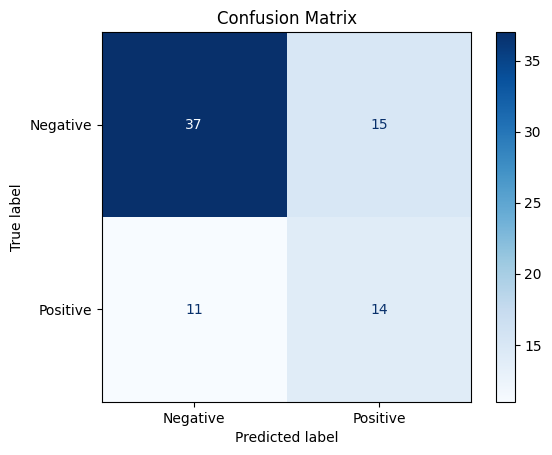


Classification Report:
              precision    recall  f1-score   support

    Negative       0.77      0.71      0.74        52
    Positive       0.48      0.56      0.52        25

    accuracy                           0.66        77
   macro avg       0.63      0.64      0.63        77
weighted avg       0.68      0.66      0.67        77

Number of selected features: 84
Shape of SHAP values: (258, 84)


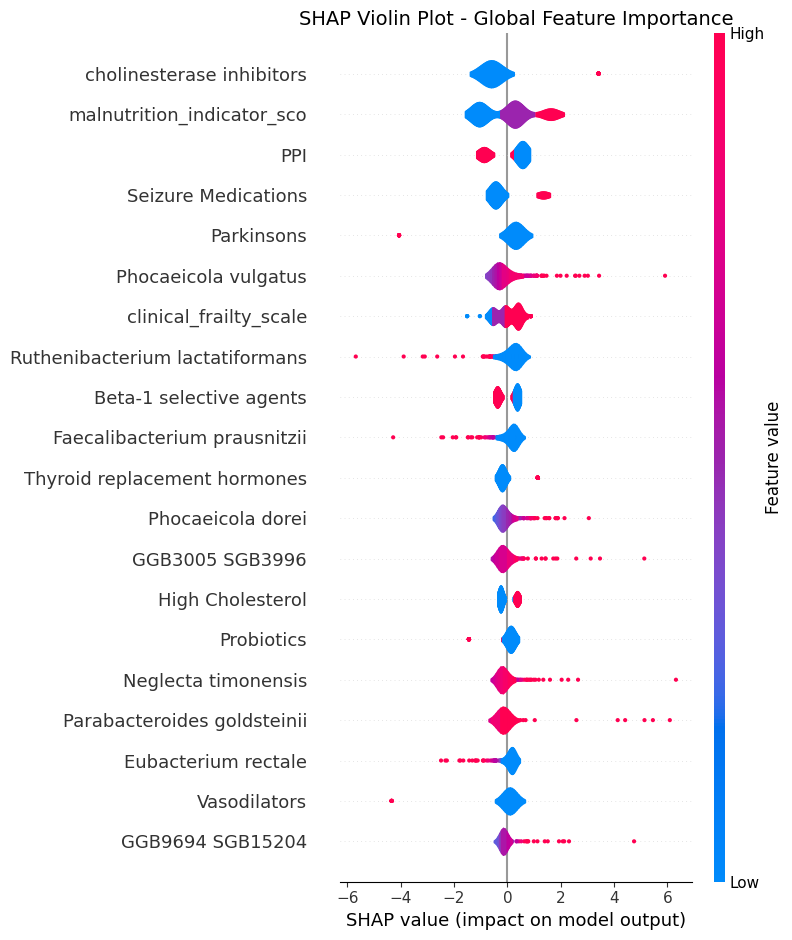

Overlap bacteria found: {'Bilophila_wadsworthia', 'Phocaeicola_vulgatus', 'Bacteroides_thetaiotaomicron', 'Catabacter_hongkongensis', 'Alistipes_putredinis', 'Alistipes_onderdonkii', 'GGB9627_SGB15081', 'Phocaeicola_dorei', 'Eggerthella_lenta', 'Eubacterium_rectale', 'Enterocloster_citroniae', 'Phascolarctobacterium_succinatutens', 'Blautia_wexlerae', 'Alistipes_finegoldii', 'Faecalibacterium_prausnitzii', 'Parabacteroides_goldsteinii', 'Massilimicrobiota_sp_An134', 'Anaeromassilibacillus_sp_An250', 'Bacteroides_xylanisolvens', 'Sellimonas_intestinalis', 'Lachnospiraceae_bacterium', 'Dysosmobacter_welbionis', 'Clostridioides_difficile', 'Ruminococcus_gnavus', 'Faecalimonas_umbilicata', 'Eggerthellaceae_unclassified_SGB14341', 'Escherichia_coli', 'GGB3433_SGB4573', 'Clostridia_bacterium', 'Clostridiales_bacterium', 'Tyzzerella_nexilis', 'Cloacibacillus_evryensis', 'Clostridiaceae_bacterium', 'Emergencia_timonensis', 'Bacteroides_fragilis', 'Clostridium_sp_AF34_10BH', 'Clostridia_bacteri

In [14]:
import optuna
from optuna.samplers import TPESampler
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import (
    roc_curve, roc_auc_score, f1_score, accuracy_score, confusion_matrix, 
    classification_report, ConfusionMatrixDisplay
)

from sklearn.model_selection import StratifiedKFold
from sklearn.utils.class_weight import compute_class_weight
import numpy as np
from sklearn.model_selection import train_test_split
from copy import deepcopy
from sklearn.preprocessing import StandardScaler

# Constants and Configuration
print(f"Experiment number: {experiment_number} | Seed number: {seed}")
# seed = experiment_seed  # Replace with your experiment seed
test_size = 0.25
gpu_device = "hist"

# Function to check for overlaps between train and test data
def check_for_overlap(train_data, test_data):
    """
    Checks for overlapping Sample ID and study_id between train and test datasets.
    """
    # Check for overlapping Study IDs
    overlap_study_ids = set(train_data["study_id"]) & set(test_data["study_id"])
    if overlap_study_ids:
        print(f"Overlap Study ID found: {overlap_study_ids}")
    else:
        print("No overlap Study ID found.")

    # Check for overlapping Sample IDs
    overlap_sample_ids = set(train_data["Sample ID"]) & set(test_data["Sample ID"])
    if overlap_sample_ids:
        print(f"Overlap Sample ID found: {overlap_sample_ids}")
    else:
        print("No overlap Sample ID found.")

def check_for_bacteria(list_a, list_b):
    """
    Checks for overlapping bactertia from list_a and list list_b database and predicted bacteria.
    """
    # Check for overlapping Study IDs
    list_a = [item.replace(" ", "_") for item in list_a]
    list_b = [item.replace(" ", "_") for item in list_b]
    
    overlap_bacteria = set(list_a) & set(list_b)
    if overlap_bacteria:
        print(f"Overlap bacteria found: {overlap_bacteria}")
    else:
        print("No overlap bacteria found.")
    return overlap_bacteria
        
def preprocess_data(df, columns_to_drop, test_size, seed):
    # Split study IDs into train/test sets
    study_labels = df.groupby("study_id")["Alzheimers"].max().reset_index()
    train_ids, test_ids = train_test_split(
        study_labels["study_id"],
        test_size=test_size,
        stratify=study_labels["Alzheimers"],
        random_state=seed,
    )
    
    train_data = df[df["study_id"].isin(train_ids)].copy()
    test_data = df[df["study_id"].isin(test_ids)].copy()

    # Check for overlaps
    check_for_overlap(train_data, test_data)
    
    # Select feature columns
    feature_columns = [col for col in df.columns if col not in columns_to_drop]

    # Convert feature columns to float64 to ensure compatibility
    train_data[feature_columns] = train_data[feature_columns].astype(np.float64)
    test_data[feature_columns] = test_data[feature_columns].astype(np.float64)

    # Normalize the feature columns
    scaler = StandardScaler()
    train_data.loc[:, feature_columns] = scaler.fit_transform(train_data[feature_columns])
    test_data.loc[:, feature_columns] = scaler.transform(test_data[feature_columns])

    return train_data, test_data, feature_columns

# Function to compute class weights
def compute_weights(y_train):
    class_weights = compute_class_weight("balanced", classes=np.unique(y_train), y=y_train)
    scale_pos_weight = class_weights[1] / class_weights[0]
    return scale_pos_weight

# Define Optuna Objective Function
def objective(trial, X_train, y_train, scale_pos_weight, seed):
    print(f"Seed in the model {seed} on Device {device}")
    # Feature selection parameters
    threshold = trial.suggest_categorical('threshold', ['median', 'mean', '0.5*mean', '1.5*mean', 'very_low'])
    max_features = trial.suggest_int('max_features', 1, X_train.shape[1])
    norm_order = trial.suggest_int('norm_order', 1, 2)
    threshold_value = -1e10 if threshold == 'very_low' else threshold

    # Feature selection
    selector = SelectFromModel(
        estimator=XGBClassifier(
            objective='binary:logistic',
            eval_metric='logloss',
            scale_pos_weight= scale_pos_weight,
            random_state=seed,
            tree_method=gpu_device, 
            device=device
        ),
        threshold=threshold_value,
        max_features=max_features,
        norm_order=norm_order
    )
    
    selector.fit(X_train, y_train)
    X_train_selected = selector.transform(X_train)

    # Define XGBoost parameters
    params = {
        'objective': 'binary:logistic',
        'eval_metric': 'logloss',
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.5),
        'max_depth': trial.suggest_int('max_depth', 3, 30),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'gamma': trial.suggest_float('gamma', 0, 10),
        'reg_alpha': trial.suggest_float('reg_alpha', 0, 10),
        'reg_lambda': trial.suggest_float('reg_lambda', 0, 10),
        'scale_pos_weight': scale_pos_weight,
        'seed': seed,
        'tree_method': gpu_device,
        'device': device
    }

    # Cross-validation
    skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=seed)
    f1_scores = []
    # Iterate over cross-validation splits
    for train_idx, val_idx in skf.split(X_train_selected, y_train):
        # Split into training and validation folds
        X_train_fold, X_val_fold = X_train_selected[train_idx], X_train_selected[val_idx]
        y_train_fold, y_val_fold = y_train[train_idx], y_train[val_idx]
        
        # Suggest hyperparameters using the Optuna trial
        C = trial.suggest_float('C', 0.001, 10.0)
        max_iter = trial.suggest_int('max_iter', 100, 1000)

        # Initialize and fit LogisticRegression model
        model = LogisticRegression(
            C=C,
            solver="liblinear",
            class_weight=class_weight,
            max_iter=max_iter,
            random_state=seed
        )
        model.fit(X_train_fold, y_train_fold)
        
        # Predict and evaluate
        y_val_pred = model.predict(X_val_fold)
        f1_scores.append(f1_score(y_val_fold, y_val_pred))
    return np.mean(f1_scores)

# Main Program
columns_to_drop = ["Sample ID", "study_id", "Alzheimers", "Date Sample", "age", "Dementia Other"] # "malnutrition_indicator_sco", "clinical_frailty_scale", "PPI", 

train_data, test_data, feature_columns = preprocess_data(clinical_microbiome_df, columns_to_drop, test_size, seed)

# Replace NAs in train_data[feature_columns] and test_data[feature_columns]
def impute_missing_values(train_data, test_data, feature_columns):
    # Calculate mean of each feature in the training set
    mean_values = train_data[feature_columns].mean()

    # Replace missing values in the training set with the computed means
    train_data[feature_columns] = train_data[feature_columns].fillna(mean_values)

    # Replace missing values in the test set with the computed means from the training set
    test_data[feature_columns] = test_data[feature_columns].fillna(mean_values)

    return train_data, test_data

# Apply the imputation
train_data, test_data = impute_missing_values(train_data, test_data, feature_columns)

X_train = deepcopy(train_data[feature_columns].values)
y_train = np.array(train_data["Alzheimers"].values)
X_test = deepcopy(test_data[feature_columns].values)
y_test = np.array(test_data["Alzheimers"].values)
scale_pos_weight = compute_weights(y_train)

class_weight = {0: 1.0, 1: scale_pos_weight}

# Run Optuna Optimization
study = optuna.create_study(direction="maximize", sampler=TPESampler(seed=seed))
study.optimize(lambda trial: objective(trial, X_train, y_train, scale_pos_weight, seed), n_trials=50)

# Best Parameters
best_params = study.best_params
print("Best Parameters:", best_params)

# Apply Final Model
final_selector = SelectFromModel(
    estimator=XGBClassifier(
        objective='binary:logistic',
        eval_metric='logloss',
        random_state=seed,
        tree_method=gpu_device,
        device=device,
        scale_pos_weight=scale_pos_weight
    ),
    
    threshold=-1e10 if best_params['threshold'] == 'very_low' else best_params['threshold'],
    max_features=best_params['max_features'],
    norm_order=best_params['norm_order']
)

final_selector.fit(X_train, y_train)
X_train_selected = final_selector.transform(X_train)
X_test_selected = final_selector.transform(X_test)

# Train Final Model
final_model = LogisticRegression(
    C=best_params['C'],
    solver="liblinear", 
    class_weight=class_weight,
    max_iter=best_params['max_iter'],
    random_state=seed
)

final_model.fit(X_train_selected, y_train)

# Predictions and Evaluation
y_test_pred = final_model.predict_proba(X_test_selected)[:, 1]
y_test_pred_binary = (y_test_pred >= 0.5).astype(int)

auc = roc_auc_score(y_test, y_test_pred)
accuracy = accuracy_score(y_test, y_test_pred_binary)
f1 = f1_score(y_test, y_test_pred_binary)
conf_matrix = confusion_matrix(y_test, y_test_pred_binary)

print("\nTest Metrics:")
print(f"ROC AUC: {auc}\nAccuracy: {accuracy}\nF1 Score: {f1}\nConfusion Matrix:\n{conf_matrix}")
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=["Negative", "Positive"])
disp.plot(cmap="Blues")
plt.title("Confusion Matrix")
plt.show()

report = classification_report(y_test, y_test_pred_binary, target_names=["Negative", "Positive"])
print("\nClassification Report:")
print(report)

# Extract feature names for selected features
selected_feature_names = [feature_columns[i] for i in final_selector.get_support(indices=True)]
print(f"Number of selected features: {len(selected_feature_names)}")

# Step 1: Initialize SHAP explainer
explainer = shap.Explainer(final_model, X_train_selected)

# Step 2: Compute SHAP values
shap_values = explainer(X_train_selected)

# Ensure SHAP values are in the correct shape for processing
print(f"Shape of SHAP values: {shap_values.values.shape}")  # Check the shape

# Truncate each feature name to a maximum of 30 characters
max_len = 40
selected_feature_names = [
    feature[:max_len] if len(feature) > max_len else feature  # Truncate if longer than 30 characters
    for feature in selected_feature_names
]

# Verify the selected feature names align with the SHAP values
assert len(selected_feature_names) == X_train_selected.shape[1], "Mismatch in feature names and SHAP input dimensions."

# Generate SHAP summary plot with corrected feature names
plt.figure(figsize=(20, 10))  # Increased width for a wider plot
plt.title("SHAP Violin Plot - Global Feature Importance", fontsize=14)

# Create summary plot with corrected feature names
shap.summary_plot(
    shap_values.values,  # SHAP values
    X_train_selected,  # Input data
    feature_names=selected_feature_names,  # Correct feature names
    max_display=20,  # Limit to top 20 features
    plot_type="violin"  # Violin plot with colors
)
plt.show()

bacteria_fount = check_for_bacteria(bacteria_df.species_name.tolist(),selected_feature_names)

In [15]:
auc

np.float64(0.6953846153846154)

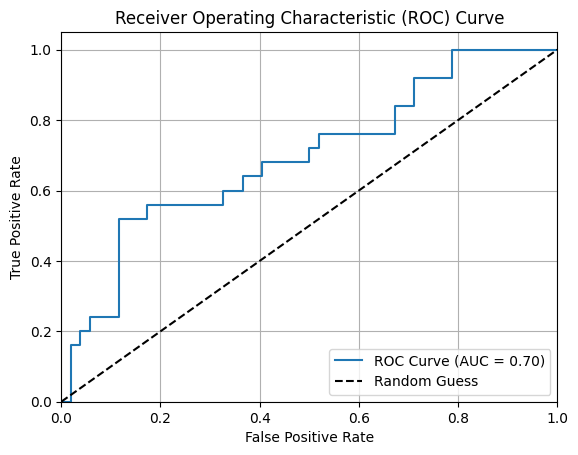

In [16]:
# Calculate the ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_test_pred)

# Plot the ROC curve
plt.figure()
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')  # Dashed diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid()
plt.show()

In [17]:
accuracy

0.6623376623376623

In [18]:
f1

np.float64(0.5185185185185185)

In [19]:
conf_matrix

array([[37, 15],
       [11, 14]])

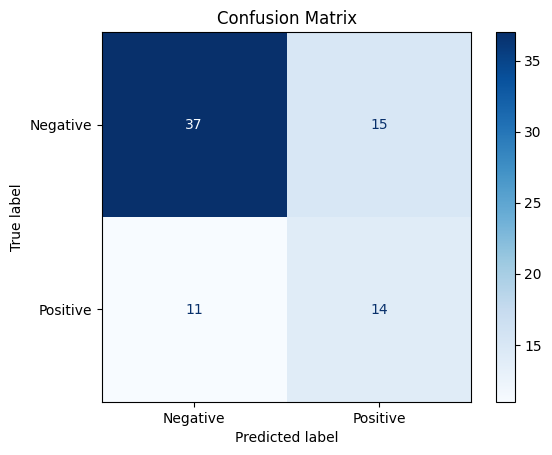

In [20]:
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=["Negative", "Positive"])
disp.plot(cmap="Blues")
plt.title("Confusion Matrix")
plt.show()

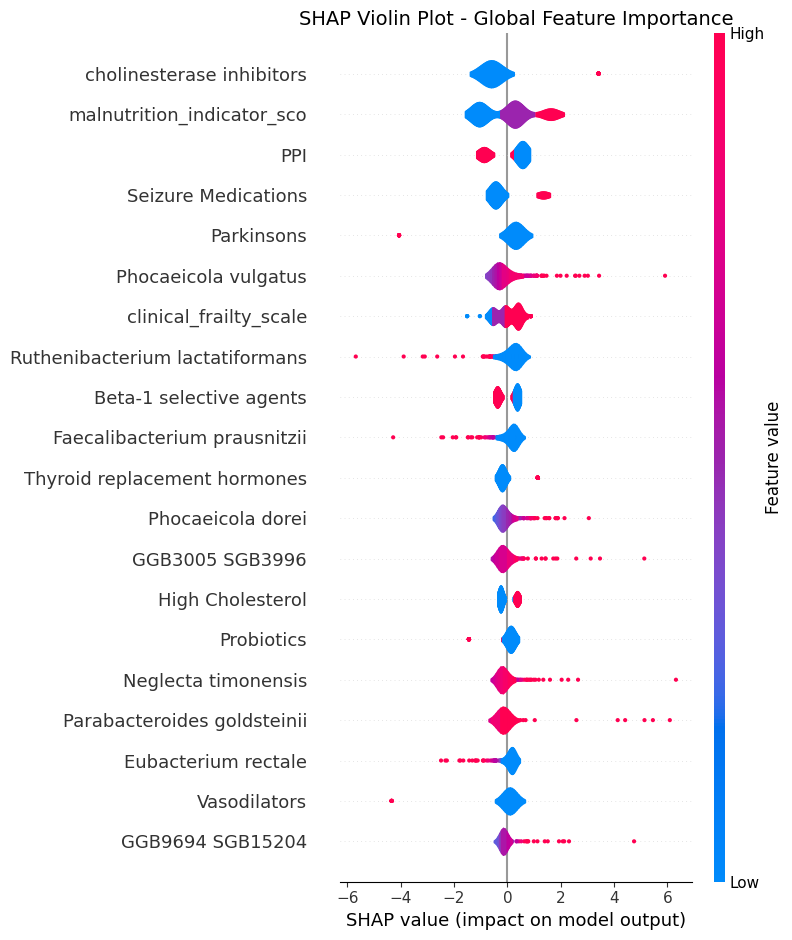

Overlap bacteria found: {'Bilophila_wadsworthia', 'Phocaeicola_vulgatus', 'Bacteroides_thetaiotaomicron', 'Catabacter_hongkongensis', 'Alistipes_putredinis', 'Alistipes_onderdonkii', 'GGB9627_SGB15081', 'Phocaeicola_dorei', 'Eggerthella_lenta', 'Eubacterium_rectale', 'Enterocloster_citroniae', 'Phascolarctobacterium_succinatutens', 'Blautia_wexlerae', 'Alistipes_finegoldii', 'Faecalibacterium_prausnitzii', 'Parabacteroides_goldsteinii', 'Massilimicrobiota_sp_An134', 'Anaeromassilibacillus_sp_An250', 'Bacteroides_xylanisolvens', 'Sellimonas_intestinalis', 'Lachnospiraceae_bacterium', 'Dysosmobacter_welbionis', 'Clostridioides_difficile', 'Ruminococcus_gnavus', 'Faecalimonas_umbilicata', 'Eggerthellaceae_unclassified_SGB14341', 'Escherichia_coli', 'GGB3433_SGB4573', 'Clostridia_bacterium', 'Clostridiales_bacterium', 'Tyzzerella_nexilis', 'Cloacibacillus_evryensis', 'Clostridiaceae_bacterium', 'Emergencia_timonensis', 'Bacteroides_fragilis', 'Clostridium_sp_AF34_10BH', 'Clostridia_bacteri

In [21]:
# Verify the selected feature names align with the SHAP values
assert len(selected_feature_names) == X_train_selected.shape[1], "Mismatch in feature names and SHAP input dimensions."

# Generate SHAP summary plot with corrected feature names
plt.figure(figsize=(20, 10))  # Increased width for a wider plot
plt.title("SHAP Violin Plot - Global Feature Importance", fontsize=14)

# Create summary plot with corrected feature names
shap.summary_plot(
    shap_values.values,  # SHAP values
    X_train_selected,  # Input data
    feature_names=selected_feature_names,  # Correct feature names
    max_display=20,  # Limit to top 20 features
    plot_type="violin"  # Violin plot with colors
)
plt.show()

bacteria_fount = check_for_bacteria(bacteria_df.species_name.tolist(),selected_feature_names)

Shape of SHAP values: (258, 84)


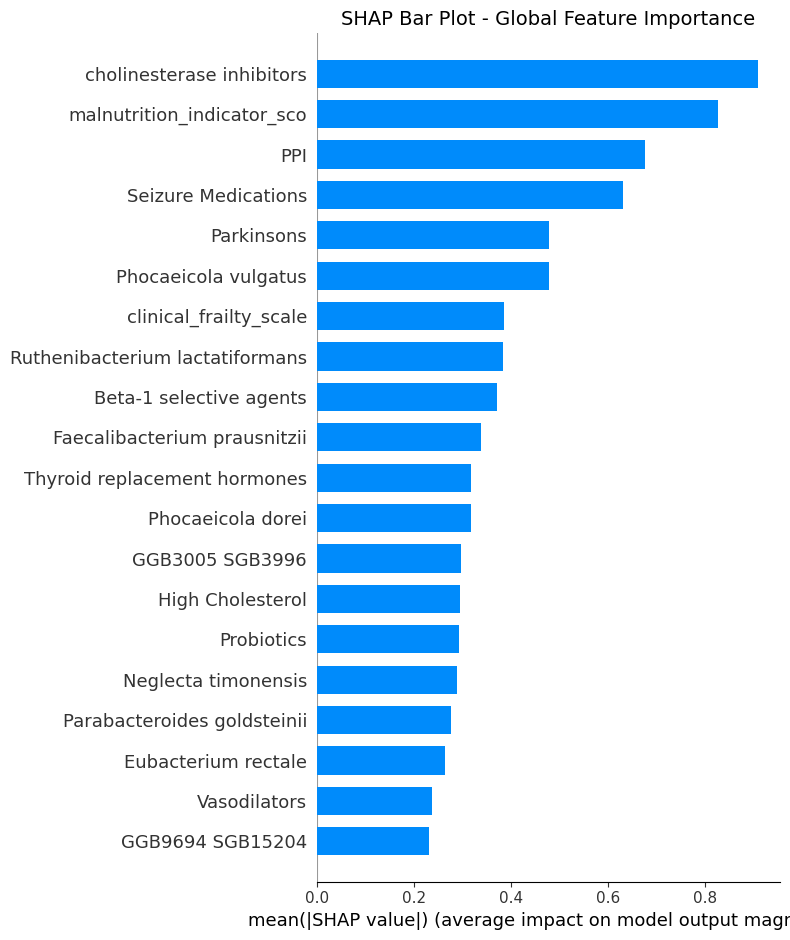

Overlap bacteria found: {'Bilophila_wadsworthia', 'Phocaeicola_vulgatus', 'Bacteroides_thetaiotaomicron', 'Catabacter_hongkongensis', 'Alistipes_putredinis', 'Alistipes_onderdonkii', 'GGB9627_SGB15081', 'Phocaeicola_dorei', 'Eggerthella_lenta', 'Eubacterium_rectale', 'Enterocloster_citroniae', 'Phascolarctobacterium_succinatutens', 'Blautia_wexlerae', 'Alistipes_finegoldii', 'Faecalibacterium_prausnitzii', 'Parabacteroides_goldsteinii', 'Massilimicrobiota_sp_An134', 'Anaeromassilibacillus_sp_An250', 'Bacteroides_xylanisolvens', 'Sellimonas_intestinalis', 'Lachnospiraceae_bacterium', 'Dysosmobacter_welbionis', 'Clostridioides_difficile', 'Ruminococcus_gnavus', 'Faecalimonas_umbilicata', 'Eggerthellaceae_unclassified_SGB14341', 'Escherichia_coli', 'GGB3433_SGB4573', 'Clostridia_bacterium', 'Clostridiales_bacterium', 'Tyzzerella_nexilis', 'Cloacibacillus_evryensis', 'Clostridiaceae_bacterium', 'Emergencia_timonensis', 'Bacteroides_fragilis', 'Clostridium_sp_AF34_10BH', 'Clostridia_bacteri

In [22]:
# Ensure SHAP values are in the correct shape for processing
print(f"Shape of SHAP values: {shap_values.values.shape}")  # Check the shape

# Truncate each feature name to a maximum of 30 characters
max_len = 40
selected_feature_names = [
    feature[:max_len] if len(feature) > max_len else feature  # Truncate if longer than 30 characters
    for feature in selected_feature_names
]

# Verify the selected feature names align with the SHAP values
assert len(selected_feature_names) == X_train_selected.shape[1], "Mismatch in feature names and SHAP input dimensions."

# Generate SHAP summary plot with corrected feature names
plt.figure(figsize=(20, 10))  # Increased width for a wider plot
plt.title("SHAP Bar Plot - Global Feature Importance", fontsize=14)

# Create summary plot with corrected feature names
shap.summary_plot(
    shap_values.values,  # SHAP values
    X_train_selected,  # Input data
    feature_names=selected_feature_names,  # Correct feature names
    max_display=20,  # Limit to top 20 features
    plot_type="bar"  # Violin plot with colors
)
plt.show()

bacteria_fount = check_for_bacteria(bacteria_df.species_name.tolist(),selected_feature_names)

In [23]:
measures = ["logisticregression", seed, experiment_number, accuracy, auc, f1]

# Create a DataFrame with appropriate column names
columns = ["Model", "Seed", "Experiment_Number", "Accuracy", "AUC", "F1_Score"]
measures_df = pd.DataFrame([measures], columns=columns)
measures_df

,Model,Seed,Experiment_Number,Accuracy,AUC,F1_Score
0,logisticregression,513873336,8,0.662338,0.695385,0.518519


In [24]:
output_path = "output"
measures_path = f"{output_path}{os.sep}logisticregression_experiment{experiment_number:02d}_measures.csv"
if output_path and not os.path.exists(output_path):
    os.makedirs(output_path)
measures_path

'output/logisticregression_experiment08_measures.csv'

In [25]:
measures_df.to_csv(measures_path, index=False)